In [188]:
import pycaret
import pandas as pd

In [189]:
# อ่านไฟล์ CSV
data = pd.read_csv('../export_data/filtered_data_3_best.csv')

In [190]:
# ตั้ง 'timestamp' เป็น index หากยังไม่ได้ทำ
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)

# ตั้งค่า freq ให้กับ index
data = data.asfreq('D')  # 'D' สำหรับรายวัน

# แสดงแถวที่มีค่าหายไปก่อนเติม
print("แถวที่มีค่าหายไปก่อนเติม:")
print(data[data.isnull().any(axis=1)])

# เติมค่าที่หายไปด้วยการ interpolate แบบเส้นตรง
data.interpolate(method='linear', inplace=True)

# แสดงแถวที่ยังมีค่า NaN หลังจากเติม (ถ้ามี)
missing_rows_after = data[data.isnull().any(axis=1)]
if not missing_rows_after.empty:
    print("แถวที่ยังมีค่าหายไปหลังเติม:")
    print(missing_rows_after)
else:
    print("ไม่มีค่าหายไปแล้ว")


# row = data.loc["2023-09-30 07:00:00"]
# row

แถวที่มีค่าหายไปก่อนเติม:
                     humidity  pm_10  pm_2_5  pm_2_5_sp  temperature
timestamp                                                           
2023-09-30 07:00:00       NaN    NaN     NaN        NaN          NaN
ไม่มีค่าหายไปแล้ว


In [191]:
# กำหนดจำนวนวันที่ต้องการเพิ่ม
num_days = 365

# สร้างวันที่ใหม่
next_date = data.index[-1] + pd.Timedelta(days=1)
new_dates = pd.date_range(start=next_date, periods=num_days, freq='D')

# สร้างแถวใหม่
new_rows = pd.DataFrame({'value': range(40, 40 + num_days)}, index=new_dates)

# รวมข้อมูล (ป้องกัน index ซ้ำซ้อน)
data = pd.concat([data, new_rows]).sort_index()

# ลบ index ที่ซ้ำกัน (ถ้ามี)
data = data.loc[~data.index.duplicated(keep='first')]

data.tail(10)

,humidity,pm_10,pm_2_5,pm_2_5_sp,temperature,value
2026-02-02 07:00:00,NaN,NaN,NaN,NaN,NaN,395.0
2026-02-03 07:00:00,NaN,NaN,NaN,NaN,NaN,396.0
2026-02-04 07:00:00,NaN,NaN,NaN,NaN,NaN,397.0
2026-02-05 07:00:00,NaN,NaN,NaN,NaN,NaN,398.0
2026-02-06 07:00:00,NaN,NaN,NaN,NaN,NaN,399.0
2026-02-07 07:00:00,NaN,NaN,NaN,NaN,NaN,400.0
2026-02-08 07:00:00,NaN,NaN,NaN,NaN,NaN,401.0
2026-02-09 07:00:00,NaN,NaN,NaN,NaN,NaN,402.0
2026-02-10 07:00:00,NaN,NaN,NaN,NaN,NaN,403.0
2026-02-11 07:00:00,NaN,NaN,NaN,NaN,NaN,404.0


In [192]:
data = data[['temperature']]

In [193]:
data["year"] = data.index.year
data["month"] = data.index.month
data["day"] = data.index.day
data["day_of_week"] = data.index.dayofweek  # 0 = Monday, 6 = Sunday
data["week_of_year"] = data.index.isocalendar().week  # ค่าจะเป็น int64

# สมมติว่า data มี index เป็น datetime อยู่แล้ว
def assign_season(month):
    if month in [2, 3, 4]:  # ก.พ. - เม.ย.
        return "summer"        # ฤดูร้อน
    elif month in [5, 6, 7]:  # พ.ค. - ก.ค.
        return "early_rainy"   # ต้นฤดูฝน
    else:  # ส.ค. - ม.ค.
        return "late_rainy"    # ปลายฤดูฝน

season_mapping = {'summer': 0, 'early_rainy': 1, 'late_rainy': 2}
data["season"] = data.index.month.map(assign_season)
data['season'] = data['season'].map(season_mapping)

data["is_weekend"] = data.index.dayofweek.isin([5, 6]).astype(int)

import pandas as pd
import numpy as np

# สมมุติว่ามี DataFrame data ที่มีข้อมูลอยู่แล้ว
# เพิ่มฟีเจอร์ day_of_year
data['date'] = pd.to_datetime(data[['year', 'month', 'day']])
data['day_of_year'] = data['date'].dt.dayofyear

# เพิ่มฟีเจอร์ month_sin และ month_cos
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

# เพิ่มฟีเจอร์ day_of_week_sin และ day_of_week_cos
data['day_of_week_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
data['day_of_week_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)

lag_size = 7
for i in range(1,lag_size+1):
    data[f'temperature_lag_{i}'] = data['temperature'].shift(i)


In [194]:
data.columns

Index(['temperature', 'year', 'month', 'day', 'day_of_week', 'week_of_year',
       'season', 'is_weekend', 'date', 'day_of_year', 'month_sin', 'month_cos',
       'day_of_week_sin', 'day_of_week_cos', 'temperature_lag_1',
       'temperature_lag_2', 'temperature_lag_3', 'temperature_lag_4',
       'temperature_lag_5', 'temperature_lag_6', 'temperature_lag_7'],
      dtype='object')

In [195]:
data_filtered = data.loc['2023-09':]  # ดึงข้อมูลตั้งแต่กันยายน 2023 เป็นต้นไป

In [196]:
data_filtered.tail()

,temperature,year,month,day,day_of_week,week_of_year,season,is_weekend,date,day_of_year,...,month_cos,day_of_week_sin,day_of_week_cos,temperature_lag_1,temperature_lag_2,temperature_lag_3,temperature_lag_4,temperature_lag_5,temperature_lag_6,temperature_lag_7
2026-02-07 07:00:00,NaN,2026,2,7,5,6,0,1,2026-02-07,38,...,0.5,-0.974928,-0.222521,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2026-02-08 07:00:00,NaN,2026,2,8,6,6,0,1,2026-02-08,39,...,0.5,-0.781831,0.623490,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2026-02-09 07:00:00,NaN,2026,2,9,0,7,0,0,2026-02-09,40,...,0.5,0.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2026-02-10 07:00:00,NaN,2026,2,10,1,7,0,0,2026-02-10,41,...,0.5,0.781831,0.623490,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2026-02-11 07:00:00,NaN,2026,2,11,2,7,0,0,2026-02-11,42,...,0.5,0.974928,-0.222521,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [197]:
# สมมติว่า data มีจำนวนวันทั้งหมด
total_data = len(data_filtered)

# จำนวนวันที่ต้องการเป็น test data
test_days = 30

# คำนวณสัดส่วนของ 30 วันในข้อมูลทั้งหมด
test_size = test_days / total_data

from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data_filtered, test_size=test_size, shuffle=False)



# Predict TEMP model

In [198]:
from pycaret.regression import load_model, predict_model

model_temp = load_model("temp_model_1")

Transformation Pipeline and Model Successfully Loaded


In [199]:
data_compare = data_filtered.loc[:'2025-01-12']
result = pd.DataFrame()

start_date = "2025-01-13"
end_date = "2026-02-11"

model = model_temp

for date in pd.date_range(start=start_date, end=end_date, freq="D"):
    # Drop columns
    test_1 = data_filtered
    # ดึงวันนี้มา
    test_1 = test_1.loc[str(date.date())]

    # ใส่เข้าไป
    data_compare = pd.concat([data_compare, test_1], axis=0)

    for i in range(1,lag_size+1):
        data_compare[f'temperature_lag_{i}'] = data_compare['temperature'].shift(i)

    # ดึง
    test_1 = (data_compare.loc[str(date.date())]).drop(columns=['temperature'])
    
    # Drop ทิ้งล่าสุดใน data_compare
    data_compare = data_compare.drop(data_compare.last_valid_index())
    test_1 = test_1[~test_1.index.duplicated(keep='last')]

    # Predict
    predict_test_1 = predict_model(model, data=test_1)

    # เพิ่มผลทำนายเข้าไปใน data_compare
    data_compare = pd.concat([data_compare, predict_test_1], axis=0)

    # แทนที่ค่าในคอลัมน์ 'pm_2_5' ในวันที่ '2025-01-13' ด้วยค่าในคอลัมน์ 'prediction_label'
    data_compare.loc[str(date.date()), 'temperature'] = data_compare.loc[str(date.date()), 'prediction_label']

    # ลบคอลัมน์ 'prediction_label' (หากต้องการแค่ผลทำนาย)
    data_compare = data_compare.drop(columns=['prediction_label'])

    # กรองเอาวันที่ซ้ำกัน (index ซ้ำ) ออกให้เหลือแค่ตัวเดียว
    data_compare = data_compare[~data_compare.index.duplicated(keep='last')]

    # บันทึกลง result
    result = pd.concat([result, predict_test_1], axis=0)

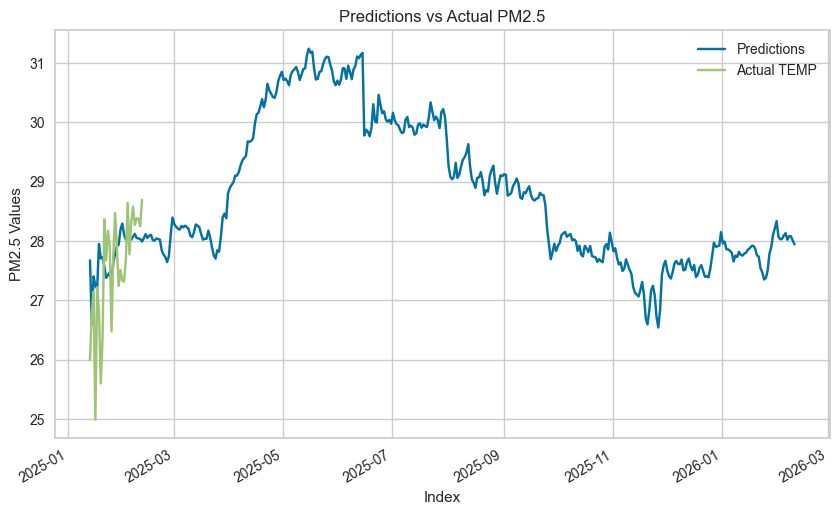

In [200]:
import pandas as pd
import matplotlib.pyplot as plt

real_data = data_filtered.loc[start_date:end_date]
# สมมุติว่า result คือ DataFrame ที่รวม predictions กับ pm_10
result_plot = pd.concat([result['prediction_label'].shift(-1), real_data['temperature']], axis=1)
result_plot.columns = ['Predictions', 'Actual TEMP']  # ตั้งชื่อคอลัมน์

# พล็อตข้อมูล
result_plot.plot(figsize=(10, 6))

# ตั้งชื่อกราฟ
plt.title('Predictions vs Actual PM2.5')
plt.xlabel('Index')
plt.ylabel('PM2.5 Values')

# แสดงกราฟ
plt.show()

In [201]:
# y_true = test_data["temperature"][:"2026-2-10"]
# y_pred = result["prediction_label"].shift(-1).dropna(axis=0)

In [202]:
# from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# # Calculate Regression Metrics
# r2 = r2_score(y_true, y_pred)
# mae = mean_absolute_error(y_true, y_pred)
# rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# # Calculate MAPE and Accuracy
# mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error
# accuracy = 100 - mape  # Convert to Accuracy %

# # Print Results
# print(f"R² Score: {r2:.4f}")
# print(f"Mean Absolute Error (MAE): {mae:.4f}")
# print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
# print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
# print(f"Accuracy: {accuracy:.2f}%")

# Predict HUMI model

In [203]:
model_humi = load_model("humi_model_1")

Transformation Pipeline and Model Successfully Loaded


In [204]:
# อ่านไฟล์ CSV
data_humi = pd.read_csv('../export_data/filtered_data_3_best.csv')

In [205]:
# ตั้ง 'timestamp' เป็น index หากยังไม่ได้ทำ
data_humi['timestamp'] = pd.to_datetime(data_humi['timestamp'])
data_humi.set_index('timestamp', inplace=True)

# ตั้งค่า freq ให้กับ index
data_humi = data_humi.asfreq('D')  # 'D' สำหรับรายวัน

# แสดงแถวที่มีค่าหายไปก่อนเติม
print("แถวที่มีค่าหายไปก่อนเติม:")
print(data_humi[data_humi.isnull().any(axis=1)])

# เติมค่าที่หายไปด้วยการ interpolate แบบเส้นตรง
data_humi.interpolate(method='linear', inplace=True)

# แสดงแถวที่ยังมีค่า NaN หลังจากเติม (ถ้ามี)
missing_rows_after = data_humi[data_humi.isnull().any(axis=1)]
if not missing_rows_after.empty:
    print("แถวที่ยังมีค่าหายไปหลังเติม:")
    print(missing_rows_after)
else:
    print("ไม่มีค่าหายไปแล้ว")

# row = data_humi.loc["2023-09-30 07:00:00"]
# row

แถวที่มีค่าหายไปก่อนเติม:
                     humidity  pm_10  pm_2_5  pm_2_5_sp  temperature
timestamp                                                           
2023-09-30 07:00:00       NaN    NaN     NaN        NaN          NaN
ไม่มีค่าหายไปแล้ว


In [206]:
# กำหนดจำนวนวันที่ต้องการเพิ่ม
num_days = 365

# สร้างวันที่ใหม่
next_date = data_humi.index[-1] + pd.Timedelta(days=1)
new_dates = pd.date_range(start=next_date, periods=num_days, freq='D')

# สร้างแถวใหม่
new_rows = pd.DataFrame({'value': range(40, 40 + num_days)}, index=new_dates)

# รวมข้อมูล (ป้องกัน index ซ้ำซ้อน)
data_humi = pd.concat([data_humi, new_rows]).sort_index()

# ลบ index ที่ซ้ำกัน (ถ้ามี)
data_humi = data_humi.loc[~data_humi.index.duplicated(keep='first')]

data_humi.tail(10)

,humidity,pm_10,pm_2_5,pm_2_5_sp,temperature,value
2026-02-02 07:00:00,NaN,NaN,NaN,NaN,NaN,395.0
2026-02-03 07:00:00,NaN,NaN,NaN,NaN,NaN,396.0
2026-02-04 07:00:00,NaN,NaN,NaN,NaN,NaN,397.0
2026-02-05 07:00:00,NaN,NaN,NaN,NaN,NaN,398.0
2026-02-06 07:00:00,NaN,NaN,NaN,NaN,NaN,399.0
2026-02-07 07:00:00,NaN,NaN,NaN,NaN,NaN,400.0
2026-02-08 07:00:00,NaN,NaN,NaN,NaN,NaN,401.0
2026-02-09 07:00:00,NaN,NaN,NaN,NaN,NaN,402.0
2026-02-10 07:00:00,NaN,NaN,NaN,NaN,NaN,403.0
2026-02-11 07:00:00,NaN,NaN,NaN,NaN,NaN,404.0


In [207]:
data_humi = data_humi[['humidity']]

In [208]:
data_humi["year"] = data_humi.index.year
data_humi["month"] = data_humi.index.month
data_humi["day"] = data_humi.index.day
data_humi["day_of_week"] = data_humi.index.dayofweek  # 0 = Monday, 6 = Sunday
data_humi["week_of_year"] = data_humi.index.isocalendar().week  # ค่าจะเป็น int64

# สมมติว่า data_humi มี index เป็น datetime อยู่แล้ว
def assign_season(month):
    if month in [2, 3, 4]:  # ก.พ. - เม.ย.
        return "summer"        # ฤดูร้อน
    elif month in [5, 6, 7]:  # พ.ค. - ก.ค.
        return "early_rainy"   # ต้นฤดูฝน
    else:  # ส.ค. - ม.ค.
        return "late_rainy"    # ปลายฤดูฝน

season_mapping = {'summer': 0, 'early_rainy': 1, 'late_rainy': 2}
data_humi["season"] = data_humi.index.month.map(assign_season)
data_humi['season'] = data_humi['season'].map(season_mapping)

data_humi["is_weekend"] = data_humi.index.dayofweek.isin([5, 6]).astype(int)

import pandas as pd
import numpy as np

# สมมุติว่ามี data_humiFrame data_humi ที่มีข้อมูลอยู่แล้ว
# เพิ่มฟีเจอร์ day_of_year
data_humi['date'] = pd.to_datetime(data_humi[['year', 'month', 'day']])
data_humi['day_of_year'] = data_humi['date'].dt.dayofyear

# เพิ่มฟีเจอร์ month_sin และ month_cos
data_humi['month_sin'] = np.sin(2 * np.pi * data_humi['month'] / 12)
data_humi['month_cos'] = np.cos(2 * np.pi * data_humi['month'] / 12)

# เพิ่มฟีเจอร์ day_of_week_sin และ day_of_week_cos
data_humi['day_of_week_sin'] = np.sin(2 * np.pi * data_humi['day_of_week'] / 7)
data_humi['day_of_week_cos'] = np.cos(2 * np.pi * data_humi['day_of_week'] / 7)

lag_size = 7
for i in range(1,lag_size+1):
    data_humi[f'humidity_lag_{i}'] = data_humi['humidity'].shift(i)


In [209]:
data_filtered = data_humi.loc['2023-09':]  # ดึงข้อมูลตั้งแต่กันยายน 2023 เป็นต้นไป

In [210]:
# สมมติว่า data มีจำนวนวันทั้งหมด
total_data = len(data_filtered)

# จำนวนวันที่ต้องการเป็น test data
test_days = 30

# คำนวณสัดส่วนของ 30 วันในข้อมูลทั้งหมด
test_size = test_days / total_data

from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data_filtered, test_size=test_size, shuffle=False)

In [211]:
data_compare = data_filtered.loc[:'2025-01-12']
result_humi = pd.DataFrame()

start_date = "2025-01-13"
end_date = "2026-02-10"

model = model_humi

for date in pd.date_range(start=start_date, end=end_date, freq="D"):
    # Drop columns
    test_1 = data_filtered
    # ดึงวันนี้มา
    test_1 = test_1.loc[str(date.date())]

    # ใส่เข้าไป
    data_compare = pd.concat([data_compare, test_1], axis=0)

    for i in range(1,lag_size+1):
        data_compare[f'humidity_lag_{i}'] = data_compare['humidity'].shift(i)

    # ดึง
    test_1 = (data_compare.loc[str(date.date())]).drop(columns=['humidity'])
    
    # Drop ทิ้งล่าสุดใน data_compare
    data_compare = data_compare.drop(data_compare.last_valid_index())
    test_1 = test_1[~test_1.index.duplicated(keep='last')]

    # Predict
    predict_test_1 = predict_model(model, data=test_1)

    # เพิ่มผลทำนายเข้าไปใน data_compare
    data_compare = pd.concat([data_compare, predict_test_1], axis=0)

    # แทนที่ค่าในคอลัมน์ 'pm_2_5' ในวันที่ '2025-01-13' ด้วยค่าในคอลัมน์ 'prediction_label'
    data_compare.loc[str(date.date()), 'humidity'] = data_compare.loc[str(date.date()), 'prediction_label']

    # ลบคอลัมน์ 'prediction_label' (หากต้องการแค่ผลทำนาย)
    data_compare = data_compare.drop(columns=['prediction_label'])

    # กรองเอาวันที่ซ้ำกัน (index ซ้ำ) ออกให้เหลือแค่ตัวเดียว
    data_compare = data_compare[~data_compare.index.duplicated(keep='last')]

    # บันทึกลง result_humi
    result_humi = pd.concat([result_humi, predict_test_1], axis=0)

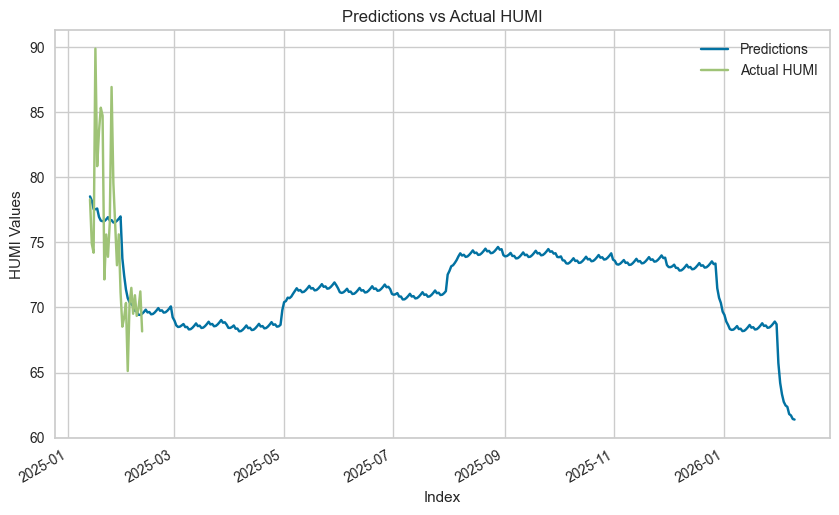

In [212]:
import pandas as pd
import matplotlib.pyplot as plt

real_data = data_filtered.loc[start_date:end_date]
# สมมุติว่า result คือ DataFrame ที่รวม predictions กับ pm_10
result_plot = pd.concat([result_humi['prediction_label'].shift(-1), real_data['humidity']], axis=1)
result_plot.columns = ['Predictions', 'Actual HUMI']  # ตั้งชื่อคอลัมน์

# พล็อตข้อมูล
result_plot.plot(figsize=(10, 6))

# ตั้งชื่อกราฟ
plt.title('Predictions vs Actual HUMI')
plt.xlabel('Index')
plt.ylabel('HUMI Values')

# แสดงกราฟ
plt.show()

In [213]:
# y_true = test_data["humidity"][:"2025-2-10"]
# y_pred = result_humi['prediction_label'].shift(-1).dropna(axis=0)

In [214]:
# # Calculate Regression Metrics
# r2 = r2_score(y_true, y_pred)
# mae = mean_absolute_error(y_true, y_pred)
# rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# # Calculate MAPE and Accuracy
# mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error
# accuracy = 100 - mape  # Convert to Accuracy %

# # Print Results
# print(f"R² Score: {r2:.4f}")
# print(f"Mean Absolute Error (MAE): {mae:.4f}")
# print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
# print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
# print(f"Accuracy: {accuracy:.2f}%")

# Predict PM2.5

In [261]:
model_pm_2_5 = load_model("pm2_5_model_1")

Transformation Pipeline and Model Successfully Loaded


In [262]:
# อ่านไฟล์ CSV
data_pm_2_5 = pd.read_csv('../export_data/filtered_data_3_best.csv')
# ลบแถวล่าสุด (แถวสุดท้าย)
data_pm_2_5 = data_pm_2_5.drop(data_pm_2_5.index[-1])

In [263]:
# ตั้ง 'timestamp' เป็น index หากยังไม่ได้ทำ
data_pm_2_5['timestamp'] = pd.to_datetime(data_pm_2_5['timestamp'])
data_pm_2_5.set_index('timestamp', inplace=True)

# ตั้งค่า freq ให้กับ index
data_pm_2_5 = data_pm_2_5.asfreq('D')  # 'D' สำหรับรายวัน

# แสดงแถวที่มีค่าหายไปก่อนเติม
print("แถวที่มีค่าหายไปก่อนเติม:")
print(data_pm_2_5[data_pm_2_5.isnull().any(axis=1)])

# เติมค่าที่หายไปด้วยการ interpolate แบบเส้นตรง
data_pm_2_5.interpolate(method='linear', inplace=True)

# แสดงแถวที่ยังมีค่า NaN หลังจากเติม (ถ้ามี)
missing_rows_after = data_pm_2_5[data_pm_2_5.isnull().any(axis=1)]
if not missing_rows_after.empty:
    print("แถวที่ยังมีค่าหายไปหลังเติม:")
    print(missing_rows_after)
else:
    print("ไม่มีค่าหายไปแล้ว")


# row = data_pm_2_5.loc["2023-09-30 07:00:00"]
# row

แถวที่มีค่าหายไปก่อนเติม:
                     humidity  pm_10  pm_2_5  pm_2_5_sp  temperature
timestamp                                                           
2023-09-30 07:00:00       NaN    NaN     NaN        NaN          NaN
ไม่มีค่าหายไปแล้ว


In [264]:
# กำหนดจำนวนวันที่ต้องการเพิ่ม
num_days = 365

# สร้างวันที่ใหม่
next_date = data_pm_2_5.index[-1] + pd.Timedelta(days=1)
new_dates = pd.date_range(start=next_date, periods=num_days, freq='D')

# สร้างแถวใหม่
new_rows = pd.DataFrame({'value': range(40, 40 + num_days)}, index=new_dates)

# รวมข้อมูล (ป้องกัน index ซ้ำซ้อน)
data_pm_2_5 = pd.concat([data_pm_2_5, new_rows]).sort_index()

# ลบ index ที่ซ้ำกัน (ถ้ามี)
data_pm_2_5 = data_pm_2_5.loc[~data_pm_2_5.index.duplicated(keep='first')]

data_pm_2_5.tail(10)

,humidity,pm_10,pm_2_5,pm_2_5_sp,temperature,value
2026-02-01 07:00:00,NaN,NaN,NaN,NaN,NaN,395.0
2026-02-02 07:00:00,NaN,NaN,NaN,NaN,NaN,396.0
2026-02-03 07:00:00,NaN,NaN,NaN,NaN,NaN,397.0
2026-02-04 07:00:00,NaN,NaN,NaN,NaN,NaN,398.0
2026-02-05 07:00:00,NaN,NaN,NaN,NaN,NaN,399.0
2026-02-06 07:00:00,NaN,NaN,NaN,NaN,NaN,400.0
2026-02-07 07:00:00,NaN,NaN,NaN,NaN,NaN,401.0
2026-02-08 07:00:00,NaN,NaN,NaN,NaN,NaN,402.0
2026-02-09 07:00:00,NaN,NaN,NaN,NaN,NaN,403.0
2026-02-10 07:00:00,NaN,NaN,NaN,NaN,NaN,404.0


In [265]:
data_pm_2_5 = data_pm_2_5.drop(columns=(['value', 'pm_2_5_sp', 'pm_10']))

In [267]:
import pandas as pd
# add humi predict column

# เลื่อนค่าของ prediction_label ไปข้างหน้า 1 วัน และตัดค่าแถวสุดท้ายที่ไม่มีผล
shifted_predictions = result_humi['prediction_label']

# สมมติว่า data_pm_2_5 และ shifted_predictions มีอยู่แล้ว
# data_pm_2_5 เป็น DataFrame ที่มีคอลัมน์ 'humidity' และ index เป็น timestamp
# shifted_predictions เป็น Series ที่มี index เป็น timestamp ในช่วงวันที่ 2025-01-13 ถึง 2025-02-10

# แทนที่ค่าของคอลัมน์ 'humidity' ใน data_pm_2_5 ด้วยค่าจาก shifted_predictions ในวันที่ตรงกัน
data_pm_2_5.loc[shifted_predictions.index, 'humidity'] = shifted_predictions
data_pm_2_5


,humidity,pm_2_5,temperature
2023-07-01 07:00:00,67.844074,11.081056,31.131941
2023-07-02 07:00:00,68.552865,9.705165,32.240924
2023-07-03 07:00:00,63.142228,11.469033,35.841610
2023-07-04 07:00:00,61.741030,26.188719,36.269393
2023-07-05 07:00:00,62.085527,25.508711,36.176134
...,...,...,...
2026-02-06 07:00:00,62.360564,NaN,NaN
2026-02-07 07:00:00,61.811107,NaN,NaN
2026-02-08 07:00:00,61.703799,NaN,NaN
2026-02-09 07:00:00,61.431320,NaN,NaN


In [268]:
# add temp predict column
shifted_predictions_temp = result['prediction_label'].shift(-1).dropna(axis=0)

data_pm_2_5.loc[shifted_predictions_temp.index, 'temperature'] = shifted_predictions_temp
data_pm_2_5

,humidity,pm_2_5,temperature
2023-07-01 07:00:00,67.844074,11.081056,31.131941
2023-07-02 07:00:00,68.552865,9.705165,32.240924
2023-07-03 07:00:00,63.142228,11.469033,35.841610
2023-07-04 07:00:00,61.741030,26.188719,36.269393
2023-07-05 07:00:00,62.085527,25.508711,36.176134
...,...,...,...
2026-02-06 07:00:00,62.360564,NaN,28.022033
2026-02-07 07:00:00,61.811107,NaN,28.083382
2026-02-08 07:00:00,61.703799,NaN,28.079696
2026-02-09 07:00:00,61.431320,NaN,28.006497


In [269]:
data_pm_2_5["year"] = data_pm_2_5.index.year
data_pm_2_5["month"] = data_pm_2_5.index.month
data_pm_2_5["day"] = data_pm_2_5.index.day
data_pm_2_5["day_of_week"] = data_pm_2_5.index.dayofweek  # 0 = Monday, 6 = Sunday
data_pm_2_5["week_of_year"] = data_pm_2_5.index.isocalendar().week  # ค่าจะเป็น int64

# สมมติว่า data_pm_2_5 มี index เป็น datetime อยู่แล้ว
def assign_season(month):
    if month in [2, 3, 4]:  # ก.พ. - เม.ย.
        return "summer"        # ฤดูร้อน
    elif month in [5, 6, 7]:  # พ.ค. - ก.ค.
        return "early_rainy"   # ต้นฤดูฝน
    else:  # ส.ค. - ม.ค.
        return "late_rainy"    # ปลายฤดูฝน

season_mapping = {'summer': 0, 'early_rainy': 1, 'late_rainy': 2}
data_pm_2_5["season"] = data_pm_2_5.index.month.map(assign_season)
data_pm_2_5['season'] = data_pm_2_5['season'].map(season_mapping)

data_pm_2_5["is_weekend"] = data_pm_2_5.index.dayofweek.isin([5, 6]).astype(int)

In [270]:
data_pm_2_5['dew_point'] = data_pm_2_5['temperature'] - ((100 - data_pm_2_5['humidity']) / 5)
# อัตราส่วนของอุณหภูมิต่อความชื้น
data_pm_2_5["temp_humidity_ratio"] = data_pm_2_5["temperature"] / (data_pm_2_5["humidity"] + 1)
# ดัชนีความร้อน (Heat Index) หรืออุณหภูมิที่รับรู้
T = data_pm_2_5["temperature"]
RH = data_pm_2_5["humidity"]

data_pm_2_5["heat_index"] = -42.379 + (2.04901523 * T) + (10.14333127 * RH) - (0.22475541 * T * RH) - \
                   (0.00683783 * T**2) - (0.05481717 * RH**2) + (0.00122874 * T**2 * RH) + \
                   (0.00085282 * T * RH**2) - (0.00000199 * T**2 * RH**2)

# ความชื้นสัมพัทธ์เชิงดัชนี
data_pm_2_5["rh_index"] = data_pm_2_5["humidity"] ** 2 / (data_pm_2_5["temperature"] + 1)

In [271]:
import pandas as pd
import numpy as np

# เพิ่มฟีเจอร์ day_of_year
data_pm_2_5['date'] = pd.to_datetime(data_pm_2_5[['year', 'month', 'day']])
data_pm_2_5['day_of_year'] = data_pm_2_5['date'].dt.dayofyear

# เพิ่มฟีเจอร์ month_sin และ month_cos
data_pm_2_5['month_sin'] = np.sin(2 * np.pi * data_pm_2_5['month'] / 12)
data_pm_2_5['month_cos'] = np.cos(2 * np.pi * data_pm_2_5['month'] / 12)

# เพิ่มฟีเจอร์ day_of_week_sin และ day_of_week_cos
data_pm_2_5['day_of_week_sin'] = np.sin(2 * np.pi * data_pm_2_5['day_of_week'] / 7)
data_pm_2_5['day_of_week_cos'] = np.cos(2 * np.pi * data_pm_2_5['day_of_week'] / 7)

lag_size = 30
for i in range(1,lag_size+1):
    data_pm_2_5[f'pm_2_5_lag_{i}'] = data_pm_2_5['pm_2_5'].shift(i)

data_pm_2_5['humidity_lag_1'] = data_pm_2_5['humidity'].shift(1)
data_pm_2_5['humidity_lag_2'] = data_pm_2_5['humidity'].shift(2)
data_pm_2_5['humidity_lag_3'] = data_pm_2_5['humidity'].shift(3)
data_pm_2_5['humidity_lag_7'] = data_pm_2_5['humidity'].shift(7)

data_pm_2_5['temperature_lag_1'] = data_pm_2_5['temperature'].shift(1)
data_pm_2_5['temperature_lag_2'] = data_pm_2_5['temperature'].shift(2)
data_pm_2_5['temperature_lag_3'] = data_pm_2_5['temperature'].shift(3)
data_pm_2_5['temperature_lag_7'] = data_pm_2_5['temperature'].shift(7)

In [272]:
data_filtered = data_pm_2_5.loc['2023-09':]  # ดึงข้อมูลตั้งแต่กันยายน 2023 เป็นต้นไป

In [274]:
data_compare = data_filtered.loc[:'2025-01-12']
result_pm_2_5 = pd.DataFrame()

start_date = "2025-01-13"
end_date = "2026-02-10"

model = model_pm_2_5

for date in pd.date_range(start=start_date, end=end_date, freq="D"):
    # Drop columns
    test_1 = data_filtered
    
    # ดึงวันนี้มา
    test_1 = test_1.loc[str(date.date())]

    # ใส่เข้าไป
    data_compare = pd.concat([data_compare, test_1], axis=0)

    for i in range(1,lag_size+1):
        data_compare[f'pm_2_5_lag_{i}'] = data_compare['pm_2_5'].shift(i)

    # ดึง
    test_1 = (data_compare.loc[str(date.date())]).drop(columns=['pm_2_5'])
    
    # Drop ทิ้งล่าสุดใน data_compare
    data_compare = data_compare.drop(data_compare.last_valid_index())
    test_1 = test_1[~test_1.index.duplicated(keep='last')]

    # Predict
    predict_test_1 = predict_model(model, data=test_1)

    # เพิ่มผลทำนายเข้าไปใน data_compare
    data_compare = pd.concat([data_compare, predict_test_1], axis=0)

    # แทนที่ค่าในคอลัมน์ 'pm_2_5' ในวันที่ '2025-01-13' ด้วยค่าในคอลัมน์ 'prediction_label'
    data_compare.loc[str(date.date()), 'pm_2_5'] = data_compare.loc[str(date.date()), 'prediction_label']

    # ลบคอลัมน์ 'prediction_label' (หากต้องการแค่ผลทำนาย)
    data_compare = data_compare.drop(columns=['prediction_label'])

    # กรองเอาวันที่ซ้ำกัน (index ซ้ำ) ออกให้เหลือแค่ตัวเดียว
    data_compare = data_compare[~data_compare.index.duplicated(keep='last')]

    # บันทึกลง result_pm_2_5
    result_pm_2_5 = pd.concat([result_pm_2_5, predict_test_1], axis=0)

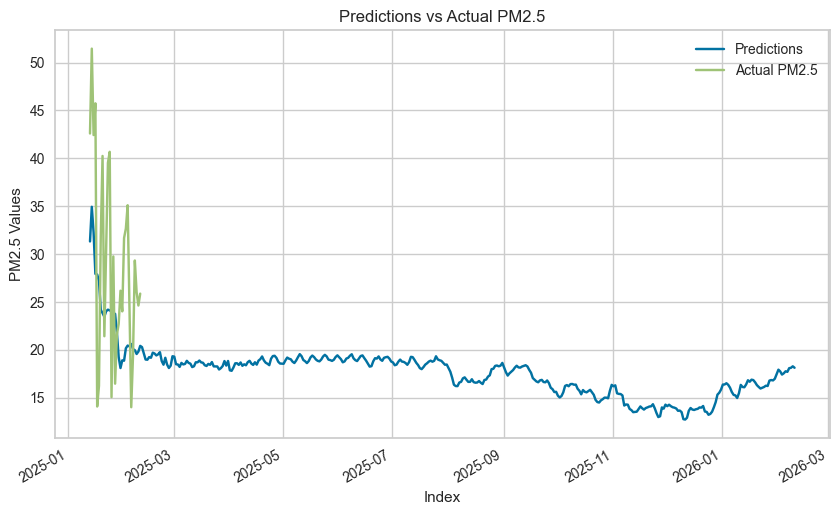

In [275]:
import pandas as pd
import matplotlib.pyplot as plt

real_data = data_filtered.loc[start_date:end_date]
# สมมุติว่า result คือ DataFrame ที่รวม predictions กับ pm_10
result_plot = pd.concat([result_pm_2_5['prediction_label'], real_data['pm_2_5']], axis=1)
result_plot.columns = ['Predictions', 'Actual PM2.5']  # ตั้งชื่อคอลัมน์

# พล็อตข้อมูล
result_plot.plot(figsize=(10, 6))

# ตั้งชื่อกราฟ
plt.title('Predictions vs Actual PM2.5')
plt.xlabel('Index')
plt.ylabel('PM2.5 Values')

# แสดงกราฟ
plt.show()

In [227]:
y_true = real_data["pm_2_5"]
y_pred = result['prediction_label']

In [228]:
# Calculate Regression Metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate MAPE and Accuracy
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error
accuracy = 100 - mape  # Convert to Accuracy %

# Print Results
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")

ValueError: Found input variables with inconsistent numbers of samples: [29, 395]